# Guide to Extracting Data w/ CardinalKit from iOS devices.

<img src="https://cardinalkit.org/img/banner-2022.png" width="500"/>


The iPhone's built-in Health app records a variety of useful health data metrics, allowing users to passively track things like sleep history, mobility, audio levels, and walking data. Measurements are taken either through the iPhone's built-in sensors, or through a peripheral device like the Apple Watch. Regardless of the data source, health data on iOS devices are stored in a centralized repository on the iPhone called HealthKit. 

This notebook will demonstrate how to extract HealthKit Data through the CardinalKit app for more rigorous analysis. In this notebook, we'll be showing you how to do just that, assuming you already have an iPhone with its Health app set up and tracking.

If you want to know more about CardinalKit, see the [DOCS](https://cardinalkit.org/cardinalkit-docs/), and for more about iPhone's Health app, see the [website](https://www.apple.com/ios/health/).

<br><br>
In this guide, we sequentially cover the following **five** topics to extract from CardinaLkit:
1. **Setup**
2. **Data extraction**
3. **Data visualization**
    - 4.1: We demo a plot from the Health app that shows daily step counts.
4. **Data analysis**
    - 4.1: We analyze whether sleep timings change significantly based on the day of the week.
    - 4.2: We analyze whether walking distance changes significantly between weekends and weekdays.
    - 4.3 We explore a relationship between walking distance and audio levels during the daytime.
    - 4.3: We check for anomalies in the data.

Disclaimer: this notebook is purely for educational purposes. All of the data currently stored in this notebook is purely *synthetic*, meaning randomly generated according to rules we created. Despite this, the end-to-end data extraction pipeline has been tested on our own data, meaning that if you enter your own credentials on your own Colab instance, you can visualize your own *real* data. 

# 1. Setup

## 1.1 Data receiver setup

1. In order for researchers to extract data from a device's HealthKit repository for a study, the study needs to have its own research app (to be installed on the said device). There are a number of ways to develop a research app, but the easiest is to utilize a framework called CardinalKit, which provides a readymade template that researchers can easily customize depending on their needs.
2. To set up the CardinalKit app itself so that you can run this notebook, you can follow the [official instructions on the website](https://cardinalkit.org/cardinalkit-docs/1-cardinalkit-app/1-start.html).
3. Please proceed to follow the steps under the headings "Create a new CardinalKit iOS app" and "Set Up Backend Infrastructure."
4. Once you have completed the above steps, navigate to Project Settings in Firebase and click "Generate new private key."
5. Download the resulting .json file and save it as serviceAccountKey.json
6. Drag and drop this file into the Files tab on the left side of the screen in this Colab notebook.

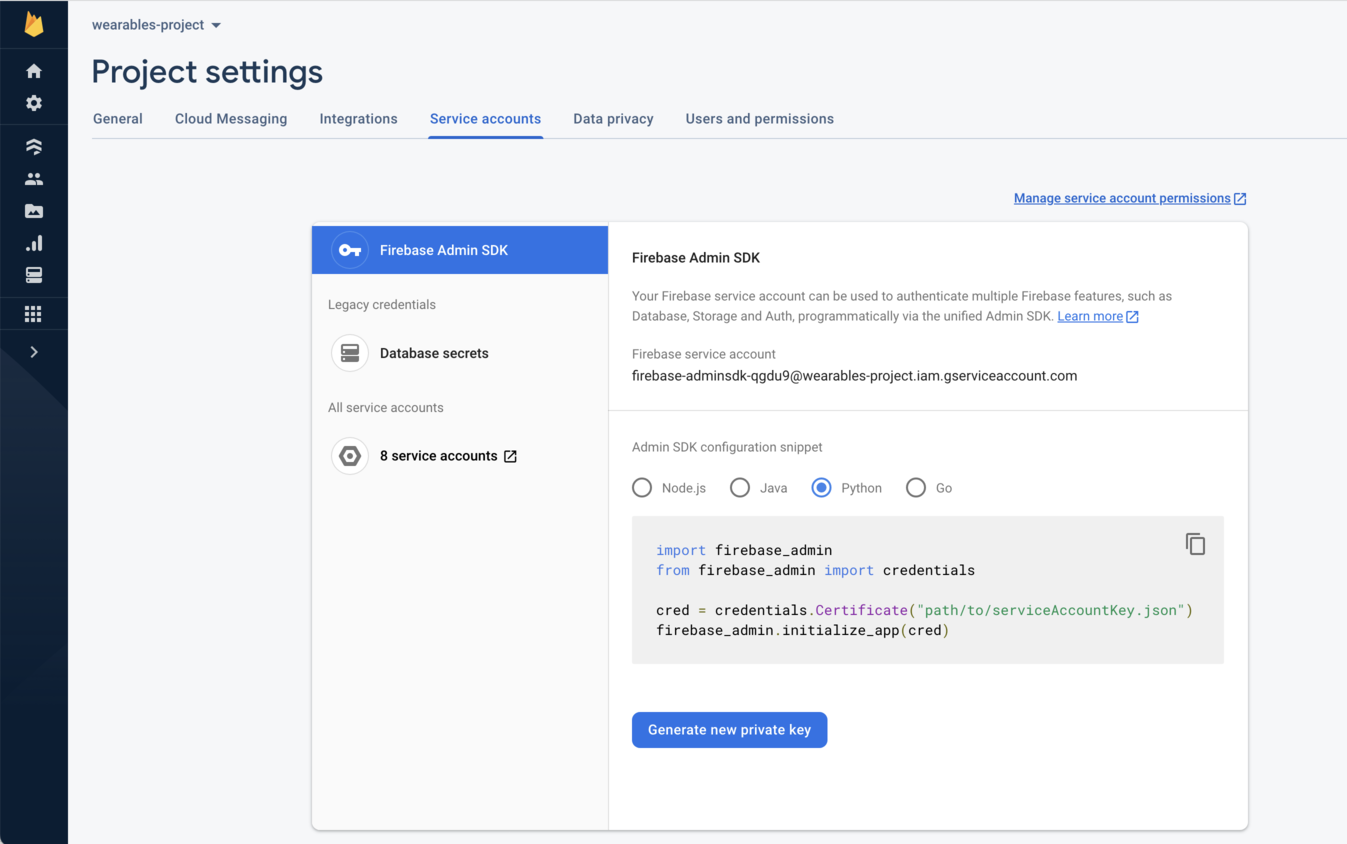

## 1.2 Study participant setup
1. Download the CardinalKit research app on your device. 
2. Open the app and proceed with onboarding.
3. Allow the app to access the necessary HealthKit data types:

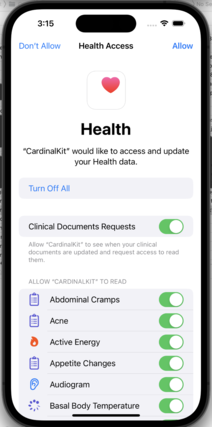

# 2. Extracting Data from Firebase



In [ ]:
# Install Firestore SDK
!pip install firebase_admin

In [92]:
# Import Firebase libraries
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

# Connect to Firestore database using private key generated by user.
cred = credentials.Certificate("serviceAccountKey.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

ValueError: ignored

In [93]:
# Get collection of user documents
users_ref = db.collection(u"studies").document(u"edu.stanford.swp").collection("users")
# Query database for collection
users = users_ref.get()

# Get list of user IDs
ids = []
for user in users:
  user_dict = user.to_dict()
  ids.append(user_dict['userID'])

# Create dictionary mapping user emails to user IDs
emails_and_ids = {}
for user in users:
  user_dict = user.to_dict()
  emails_and_ids[user_dict['email']] = user_dict['userID']

print(emails_and_ids)

{'parthavshergill@gmail.com': 'brwHI196pqQWftiJYRYl1ez8YHz1'}


In [94]:
# Get list of user hkdata streams using each user's id:
user_hkdata_streams = []
for id in ids:
  user_hkdata_streams.append(users_ref.document(id).collection('healthKit').stream())

In [95]:
# Create dictionary mapping id to observations
user_observations = {}
for id, stream in zip(ids, user_hkdata_streams):
  observations = [obs for obs in stream]
  user_observations[id] = observations

print(user_observations)

{'brwHI196pqQWftiJYRYl1ez8YHz1': [<google.cloud.firestore_v1.base_document.DocumentSnapshot object at 0x7f73fca5fdc0>, <google.cloud.firestore_v1.base_document.DocumentSnapshot object at 0x7f73fca5fb80>, <google.cloud.firestore_v1.base_document.DocumentSnapshot object at 0x7f73fca5f880>, <google.cloud.firestore_v1.base_document.DocumentSnapshot object at 0x7f73fca5f160>, <google.cloud.firestore_v1.base_document.DocumentSnapshot object at 0x7f73fca5f670>, <google.cloud.firestore_v1.base_document.DocumentSnapshot object at 0x7f7407cbc610>, <google.cloud.firestore_v1.base_document.DocumentSnapshot object at 0x7f7407cbc6a0>, <google.cloud.firestore_v1.base_document.DocumentSnapshot object at 0x7f7407cbc430>, <google.cloud.firestore_v1.base_document.DocumentSnapshot object at 0x7f7407cbc2b0>, <google.cloud.firestore_v1.base_document.DocumentSnapshot object at 0x7f7407cbcf10>, <google.cloud.firestore_v1.base_document.DocumentSnapshot object at 0x7f7407cbc490>, <google.cloud.firestore_v1.base

In [99]:
#@title Get User ID
email = "parthavshergill@gmail.com" #@param {type:"string"}
user_id = emails_and_ids[user_dict['email']]
print(user_id)

brwHI196pqQWftiJYRYl1ez8YHz1


In [151]:
#@title Would you like to use simulated data?
should_simulate = True #@param {type:"boolean"}

import numpy as np
from datetime import *
import pandas as pd

def scale_range (input, min, max):
    out = input.copy()
    out += -(np.min(input))
    out /= np.max(input) / (max - min)
    out += min
    return out

if should_simulate:
  # Create dictionary with body dictionary inside with step and heart rate
  simulated_observations = {}
  simulated_observations[user_id] = []
  date_range = np.asarray(pd.date_range(date.today() - timedelta(days=30), periods=30))
  print(date_range)
  step_counts = np.asarray([np.random.normal(10000, 3000) for i in range(30)])
  heart_rates = scale_range(step_counts, 50, 110) + np.random.normal(3, 5, 30)
  for i in range(30):
    simulated_observations[user_id].append({'body': {'step_count': step_counts[i], 'heart_rate': heart_rates[i], 'effective_time_frame': {'date_time': date_range[i]}}})
  
print(simulated_observations)

['2023-02-14T00:00:00.000000000' '2023-02-15T00:00:00.000000000'
 '2023-02-16T00:00:00.000000000' '2023-02-17T00:00:00.000000000'
 '2023-02-18T00:00:00.000000000' '2023-02-19T00:00:00.000000000'
 '2023-02-20T00:00:00.000000000' '2023-02-21T00:00:00.000000000'
 '2023-02-22T00:00:00.000000000' '2023-02-23T00:00:00.000000000'
 '2023-02-24T00:00:00.000000000' '2023-02-25T00:00:00.000000000'
 '2023-02-26T00:00:00.000000000' '2023-02-27T00:00:00.000000000'
 '2023-02-28T00:00:00.000000000' '2023-03-01T00:00:00.000000000'
 '2023-03-02T00:00:00.000000000' '2023-03-03T00:00:00.000000000'
 '2023-03-04T00:00:00.000000000' '2023-03-05T00:00:00.000000000'
 '2023-03-06T00:00:00.000000000' '2023-03-07T00:00:00.000000000'
 '2023-03-08T00:00:00.000000000' '2023-03-09T00:00:00.000000000'
 '2023-03-10T00:00:00.000000000' '2023-03-11T00:00:00.000000000'
 '2023-03-12T00:00:00.000000000' '2023-03-13T00:00:00.000000000'
 '2023-03-14T00:00:00.000000000' '2023-03-15T00:00:00.000000000']
{'brwHI196pqQWftiJYRYl1e

# 4. Data Visualization





In [153]:
#@title Select metric to extract
metric = "heart_rate" #@param ["step_count", "heart_rate"] {allow-input: true}
# Get step observations and observation timings for the user 
if should_simulate:
  observations = simulated_observations[user_id]
else:
  observations = user_observations[user_id]
metric_data = []
step_count_data = []
heart_rate_data = []
time_recorded = []
for obs in observations:
  if not should_simulate:
    obs_dict = obs.to_dict()
  else:
    obs_dict = obs
  if metric in obs_dict['body']:
    metric_count = obs_dict['body'][metric]
    metric_data.append(metric_count)
    time = obs_dict['body']['effective_time_frame']['date_time']
    time_recorded.append(time)
  try:
    # Get sleep and heart rate data anyway for later data analysis
    step_count_data.append(obs_dict['body']['step_count'])
    heart_rate_data.append(obs_dict['body']['heart_rate'])
  except:
    pass

print(len(step_count_data))

30


In [148]:
#@title Visualizing activity
from datetime import datetime 

# Convert observation timings to datetime objects
timestamps = []
for time_string in time_recorded:
  if should_simulate:
    timestamp = pd.Timestamp(time_string)
  else:
    timestamp = datetime.strptime(time_string[:-6], '%Y-%m-%dT%H:%M:%S.000')
  timestamps.append(timestamp)

# Combine data
dataset = []
for time, data in zip(timestamps, metric_data):
  if isinstance(data, dict):
    dataset.append((time, data['value']))
  else:
    dataset.append((time, data))


# Sort combined dataset in order of when observation was recorded:
dataset.sort(key=lambda x: x[0])

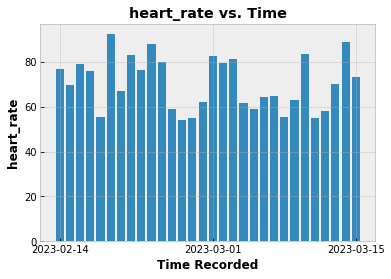

In [149]:
import matplotlib.pyplot as plt

# Plot timestamps against step count
x_data, y_data = zip(*dataset)

with plt.style.context('bmh'):
  plt.bar(x_data, y_data)
  plt.xlabel('Time Recorded', fontweight='bold')
  plt.ylabel(metric, fontweight='bold')
  plt.title(metric +" vs. Time", fontweight='bold')
  plt.xticks(ticks=[x_data[0], x_data[len(x_data)//2], x_data[-1]])
  plt.show()

*Above is a plot we created ourselves!*

# 5. Data Analysis

Data isn't much without some analysis, so we're going to do some in this section.

DISCLAIMER: the analyses below may not be 100% biologically or scientifically grounded; the code is here to assist in your process, if you are interested in asking these kinds of questions.

## 5.1: Investigating a Correlation between Heart Rate and Step Count

Different levels of physical intensity impact heart rate differently - here, we will use step count as a proxy for physical activity. Here, we hypothesize that there is a correlation between step count and physical activity.

Here, we will test our data to see whether step count is correlated with heart rate. 

First, to get an intuitive understanding of the data, we can plot a scatterplot of sleep duration (in seconds) against sleep scores.

DISCLAIMER: The simulated data (by construction) creates a relationship between step count and heart rate. This data is not based on empirical measurements.

<AxesSubplot:>

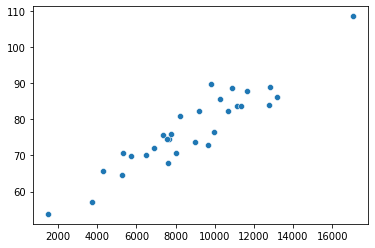

In [154]:
import seaborn as sns

sns.scatterplot(x=step_count_data, y=heart_rate_data)

As expected, there is a positive trend here - it appears that higher step counts are related to higher heart rates. However, let us analyze this more rigorously. To provide strong quantitative evidence in favor of our claim, we look at two things. 

First, we calculate the Pearson Correlation Coefficient, which is a normalized measure of how much two random variables co-vary. A correlation coefficient close to +/- 1 indicates a strong correlation, while a correlation close to 0 indicates no correlation.

In [155]:
from scipy import stats

corr, _ = stats.pearsonr(step_count_data, heart_rate_data)
corr

0.9309993755306485

As we can see, the correlation is close to 1, which indicates a strong correlation (strong positive linear relationship) between step count and heart rate in our dataset. Just to reiterate: This is to be expected given our construction of sleep scores.

Now, we assess the null hypothesis via regression analysis. The null hypothesis is the statement that step count is not related to heart rates. More formally, we test the hypothesis that the regression coefficient of sleep length in our regression model is equal to 0. To test this, we can calculate the probability that this observed relationship occurred due to random chance. This probability is known as the p-value. 

In [156]:
slope, intercept, r_value, p_value, std_err = stats.linregress(heart_rate_data, step_count_data)
print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: 276
Coefficient of determination: 0.867
p-value: 8.88e-14


The above p-value is far, far smaller than our alpha threshold of 0.05. This indicates that the relationship is statistically significant, and we can conclude that the null hypothesis is false. Therefore, the relationship between step counts and heart rate is statistically significant.

Of course, this p-value is incredibly small due to our construction of the simulated data. Such a small value would not occur with real data, but the same procedure for analysis can be followed.

In [159]:
# Create response and predictor vectors
x = step_count_data
y = heart_rate_data

# Training/test data split:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101)

# Fit least squares regression and print summary:
import statsmodels.api as sm
x_train_Sm = sm.add_constant(x_train)
ls = sm.OLS(y_train,x_train_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     174.3
Date:                Thu, 16 Mar 2023   Prob (F-statistic):           5.07e-11
Time:                        07:36:30   Log-Likelihood:                -57.490
No. Observations:                  21   AIC:                             119.0
Df Residuals:                      19   BIC:                             121.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.4680      2.252     21.519      0.0

Above, we have fit a linear regression to the data. Now, we begin to evaluate the 'goodness of fit.'

In order to do this, we can look at the R-squared value in the top right of the table. An R-squared value of close to 1 is an indication that most of the variance in the data is explained by our model - i.e., our model fits the data well.

In general, R-squared ranges from 0 to 1: 0 implies a poor linear fit, while 1 implies a perfect fit. 

We can look also look at adjusted R-squared to look at how the model performs. Adjusted R-squared is the same as R-squared, but adjusts for the number of covariates in our regression. Since we have only one covariate in our regression (sleep duration), the adjusted R-squared is the same as the R-squared value.

Now, we move on to make predictions on our data:

In [160]:
x_test_Sm = sm.add_constant(x_test)
y_pred = ls.predict(x_test_Sm)

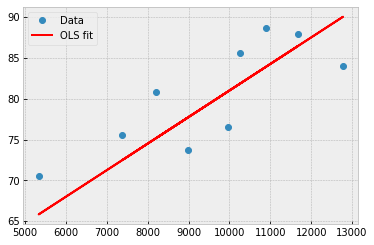

In [161]:
with plt.style.context('bmh'):
  fig, ax = plt.subplots()
  ax.plot(x_test, y_test, "o", label="Data")
  ax.plot(x_test, y_pred, "r", label="OLS fit")
  ax.legend(loc="best")

From above, it appears that our linear regression model fits the data quite well. To calculate a point estimate of just how well the model fits, we can also calculate the test mean squared error of our model:

In [162]:
mse = ((y_test - y_pred)**2).mean()
print(mse)

19.22503431277085


Finally, we can validate the linear regression assumption that the errors are normally distributed, in order to ensure that our results constitute a valid regression. To do so, we can plot the residuals.

From below, it appears that the residuals (errors) of our model's predictions follow a normal distribution (roughly, as we have a small sample size), so the linear regression assumption appears reasonable.

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

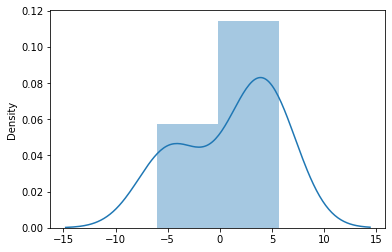

In [163]:
residuals = y_test - y_pred
sns.distplot(residuals)